In [73]:
library(tidyverse)
library(caret)
library(ggpubr)
library(FactoMineR)

Warning message:
"package 'FactoMineR' was built under R version 3.6.3"

In [99]:
donnees1 <- read_csv("donnees1.csv")
donnees2 <- read_csv("donnees2.csv")
medical <- read_csv2("medical.csv")

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double()
)
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.
Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


## Questions de cours

1. Expliquer la différence entre un problème de classification (non supervisée) et un problème de classification supervisée (ou discrimination).

En classification supervisée, on possède les étiquettes pour les données qu'on veut classer. Le clustering est plus considéré comme une approche exploratoire des données puisqu'on n'a pas les étiquettes mais on veut les rassembler en fonction de leurs similarités.

2. Je dois faire une classification non supervisée. Expliquer de façon synthétique les difficultés pratiques que je risque de rencontrer pour les principaux algorithmes vus en cours.

En clustering, on peut rencontrer de façon générale plusieurs problèmes:

- le choix des variables pertinentes
- le poids à donner entre les similarités et les dissimilarités
- en CAH, le compromis entre les valeurs d'inertie et le nombre de groupes, ainsi que la vitesse: $O(n^2)$ opérations

## Exercice 1

On considère le jeu de données **donnees1.csv**. Ce jeu contient 300 observations et 2 variables **X1** et **X2** quantitatives. On souhaite faire une classification.

  1. Importer les données et représenter le nuage de points

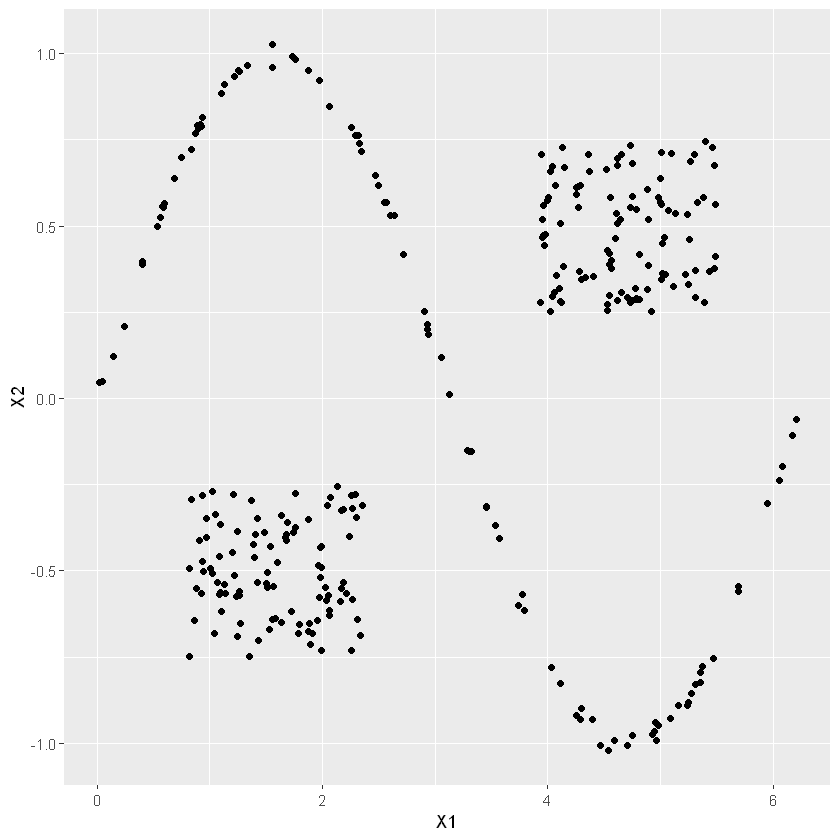

In [9]:
ggplot(donnees1) +
aes(X1, X2) + geom_point()

  2. En vous basant uniquement sur le nuage de points, que pouvez-vous dire sur le nombre de groupes pour ces données ?
  
On peut considérer visuellement qu'on a 3 groupes.
  
  3. Effectuer une classification ascendante hiérarchique en utilisant comme distance ultramétrique (ou méthode d'agglomération) le saut maximal (complete linkage). Représenter le nuage de points en coloriant les observations selon leur groupe, on utilisera le nombre de groupes décidé à la question précédente.

  4. Même question avec la distance de Ward comme distance ultramétrique.

  5. Même question avec le saut minimal comme distance ultramétrique (single linkage).

  6. Faire de même pour l'algorithme des **k-means**, on utilisera les paramètres par défaut de la fonction **kmeans**.
  
  7. Parmi les 4 méthodes effectuées, laquelle vous semble être la plus pertinente ? Essayez d'expliquer les raisons de sa supériorité.

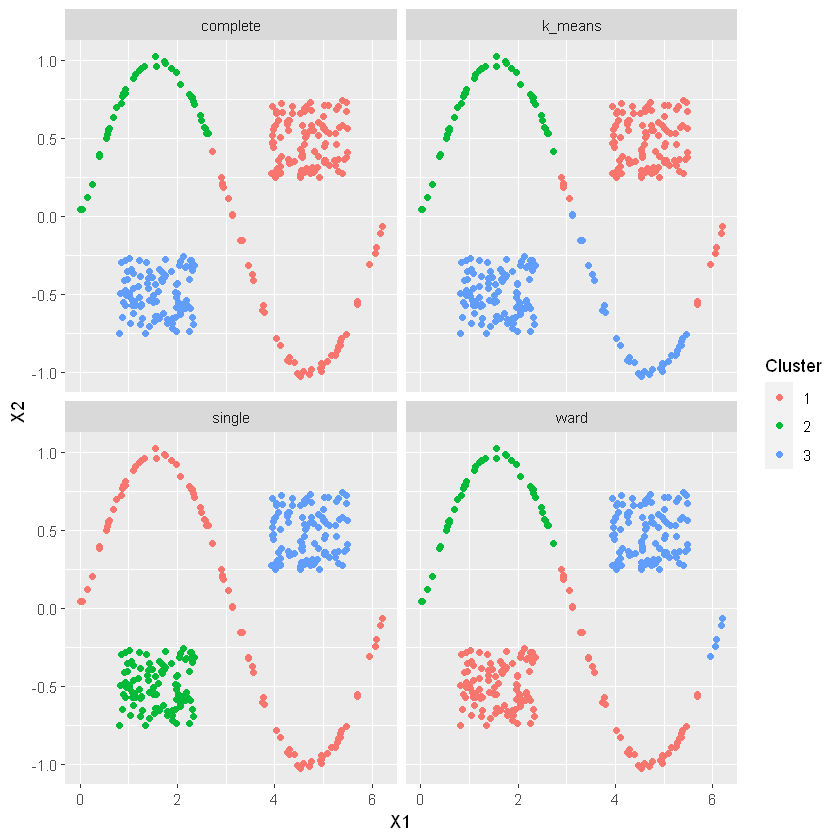

In [22]:
set.seed(2020)
scaled_1 <- scale(donnees1)
dist_1 <- dist(scaled_1)

complete <- hclust(dist_1, method = "complete") %>% cutree(k = 3)
ward <- hclust(dist_1, method = "ward.D") %>% cutree(k = 3)
single <- hclust(dist_1, method = "single") %>% cutree(k = 3)
k_means <- kmeans(scaled_1, 3)$cluster

donnees1 %>% 
mutate(complete, ward, single, k_means) %>% 
gather("Algorithm", "Cluster", -c(X1, X2)) %>% 
mutate(Cluster = as.factor(Cluster)) %>% 
ggplot() + aes(X1, X2, color = Cluster) +
geom_point() + facet_wrap(.~Algorithm)

Nous avons centré et réduit les données et nous utilisons la distance euclidienne puisqu'il s'agit de données quantitatives.

Au vu des résultats, l'algorithme CAH par single linkage est la meilleure puisqu'elle classe les groupes de façon homogène en suivant les silhouettes.

## Exercice 2



On considère le jeu de données **donnees2.csv**. Ce jeu contient 600 observations et 20 variables quantitatives. On souhaite faire une classification pour séparer les individus en groupe.

  1. Effectuer plusieurs CAH (on pourra utiliser différentes distances ultramétriques).

In [65]:
set.seed(2020)
scaled_2 <- scale(donnees2)
dist_2 <- dist(scaled_2)

complete <- hclust(dist_2, method = "complete")
ward <- hclust(dist_2, method = "ward.D")
ward2 <- hclust(dist_2, method = "ward.D2")
single <- hclust(dist_2, method = "single")
average <- hclust(dist_2, method = "average")

  2. A partir des dendrogrammes de ces classifications choisir un nombre de groupes pour ce problème en justifiant brièvement votre choix.
  
En visualisant les courbes de perte de l’inertie inter-classes, on choisirait la distance au carrée de Ward avec 3 clusters.

In [66]:
heights <- tibble(
    complete = sort(complete$height, decreasing = T)[1:10],
    ward = sort(ward$height, decreasing = T)[1:10],
    ward2 = sort(ward2$height, decreasing = T)[1:10],
    single = sort(single$height, decreasing = T)[1:10],
    average = sort(average$height, decreasing = T)[1:10],
)


hplots <- vector(mode = "list")
for (method in names(heights)){
    hplots[[method]] <- ggplot(heights) + 
    aes_string(x = 1:10, y = method) + geom_bar(stat = "identity") +
    labs(title = method, y = "H") + 
    theme(plot.title = element_text(hjust = 0.5))
}

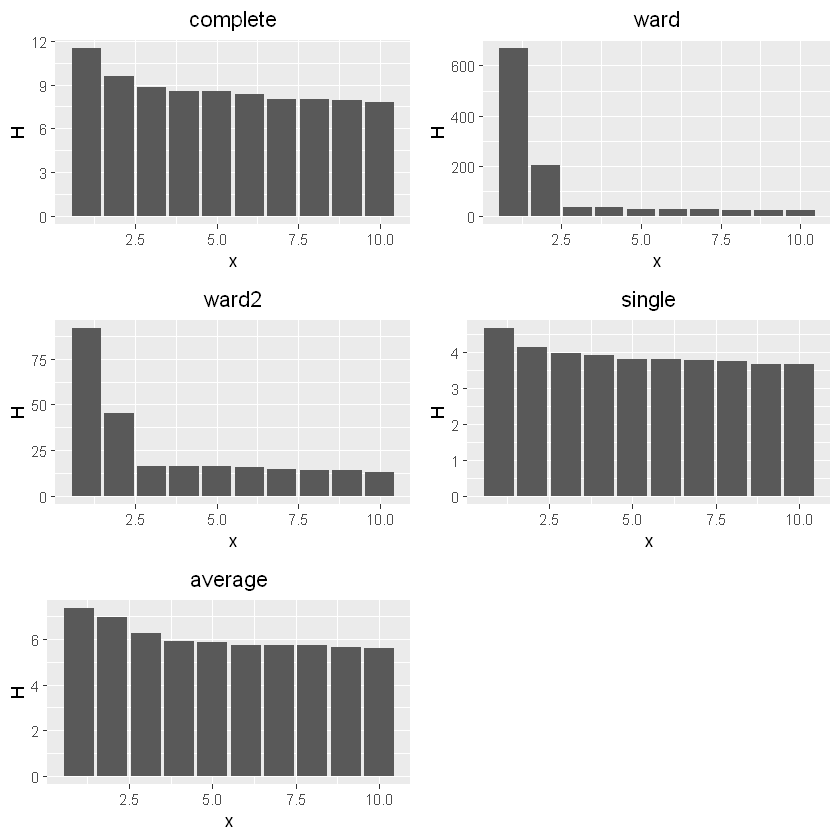

In [68]:
ggarrange(
    plotlist = hplots,
    ncol = 2, nrow = 3
)

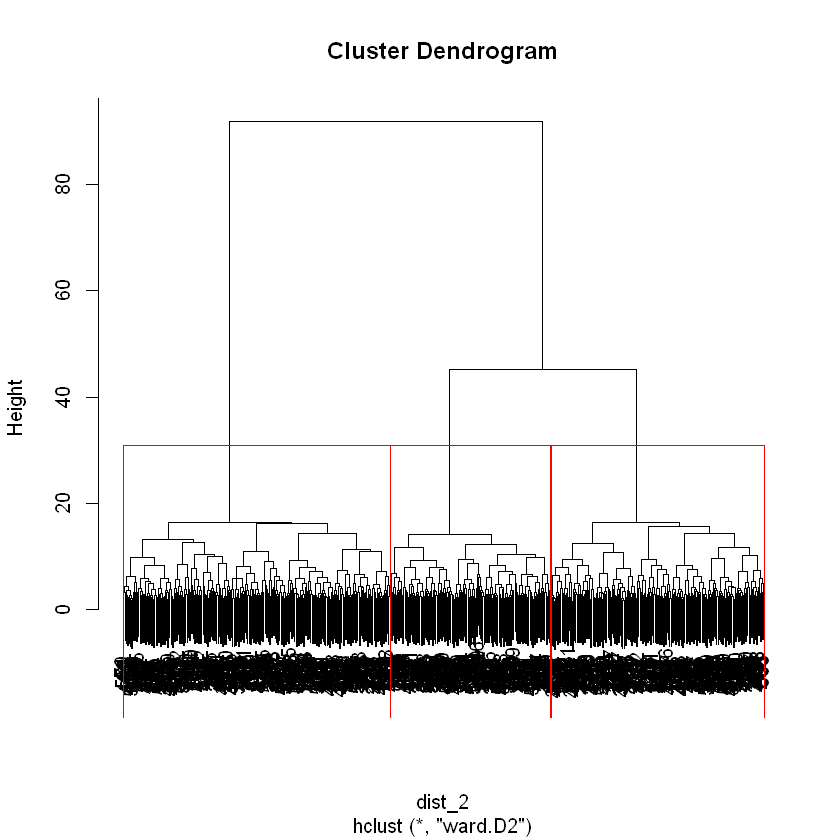

In [69]:
plot(ward2)
rect.hclust(ward2, 3)

  3. Calculer les groupes de ces observations. On pourra stocker ces groupes dans un vecteur **groupe** de longueur 600 qui permettra d'idenfifier le groupe choisi pour chaque observation.

In [100]:
group <- as.factor(cutree(ward2, 3))

  4. Visualiser les groupes à l'aide d'une ACP. On effectuera une ACP du jeu de données initial et on représentera les groupes sur le premier plan factoriel (il suffira de colorier les individus en fonction des groupes).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


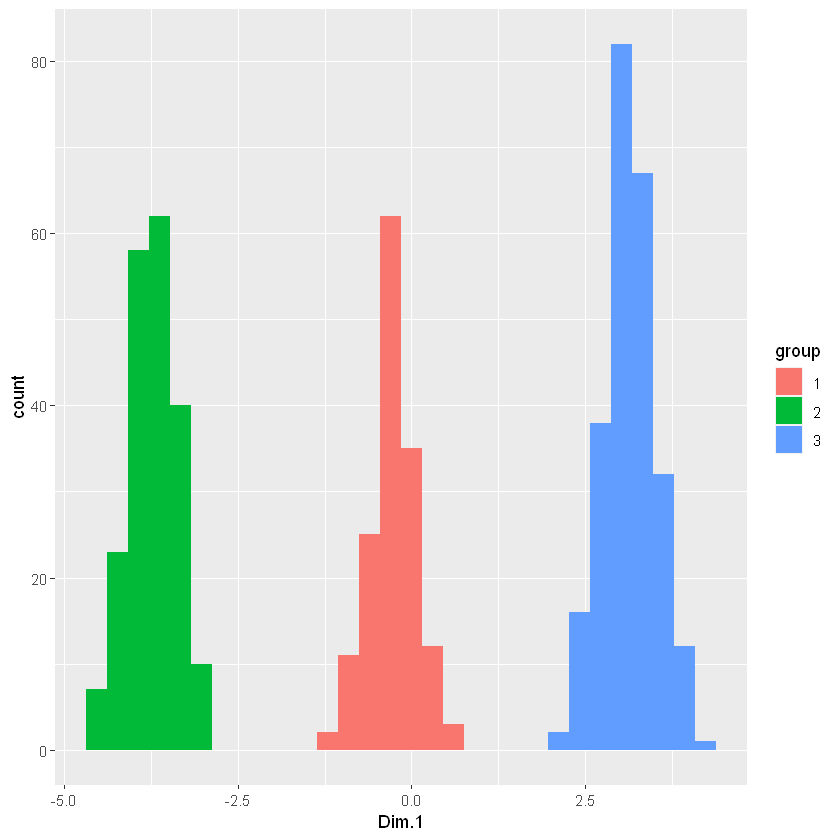

In [106]:
pca_donnees2 <- PCA(donnees2, scale.unit = T, ncp = 1, graph = F) 

pca_donnees2$ind$coord %>% 
as_tibble() %>% ggplot() +
aes(x = Dim.1) + geom_histogram(aes(fill = group))

  5. Refaire le graphe de la question précédente pour des groupes obtenus avec un **kmeans** (on pourra utiliser le même nombre de groupes).
  


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


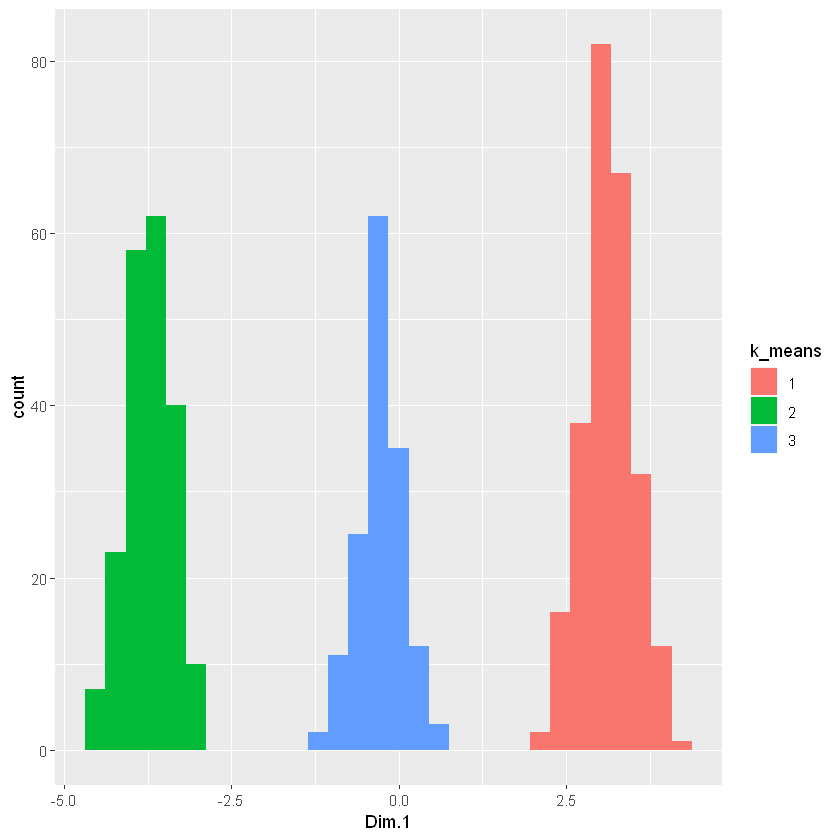

In [109]:
set.seed(2020)
k_means <- kmeans(scaled_2, 3)$cluster %>% as.factor()

pca_donnees2$ind$coord %>% 
as_tibble() %>% ggplot() +
aes(x = Dim.1) + geom_histogram(aes(fill = k_means))

## Exercice 3  

Les données de cet exercice se trouvent dans le fichier **medical.csv**. Ce fichier contient 108 variables et 68 individus. Les variables correspondent à des descripteurs quantitatifs déduits d'une IRM qui a été effectué sur la patient.

1. Effectuer une classification qui permette de regrouper les individus en un nombre restreint de classe. On pourra utiliser plusieurs méthodes (3 ou 4, pas plus) pour décicder du nombre de groupes et comparer les groupes obtenus par les différents algorithmes pour décider des groupes finaux.

On essaie d'avoir une inertie inter-classe qui baisse le moins, alors on utilise la méthode de Ward.  
On ajoutera aussi la méthode des moyennes.

In [113]:
set.seed(2020)
scaled_3 <- scale(medical)
dist_3 <- dist(scaled_3)

ward <- hclust(dist_3, method = "ward.D")
average <- hclust(dist_3, method = "average")

In [158]:
heights <- tibble(
    ward = sort(ward$height, decreasing = T)[1:10],
    average = sort(average$height, decreasing = T)[1:10]
)


hplots <- vector(mode = "list")
for (method in names(heights)){
    hplots[[method]] <- ggplot(heights) + 
    aes_string(x = 1:10, y = method) + geom_bar(stat = "identity") +
    labs(title = method, y = "H") + 
    theme(plot.title = element_text(hjust = 0.5))
}

Créons une fonction qui modélise la perte d'inertie pour chaque coupure.  
Nous prendrons la coupure avec la perte relative minimale.

In [204]:
bestcut <- function(arbre, min = 2, max = 10){
    #' Renvoie un plot de la perte d'intertie
    intra <- rev(cumsum(arbre$height))
    tibble(
        cut = min:max,
        loss = intra[min:(max)]/intra[(min - 1):(max - 1)]
    ) %>% 
    ggplot() + aes(x = cut, y = loss) + geom_point()
}

Il semble pertinent d'avoir 2 coupures.

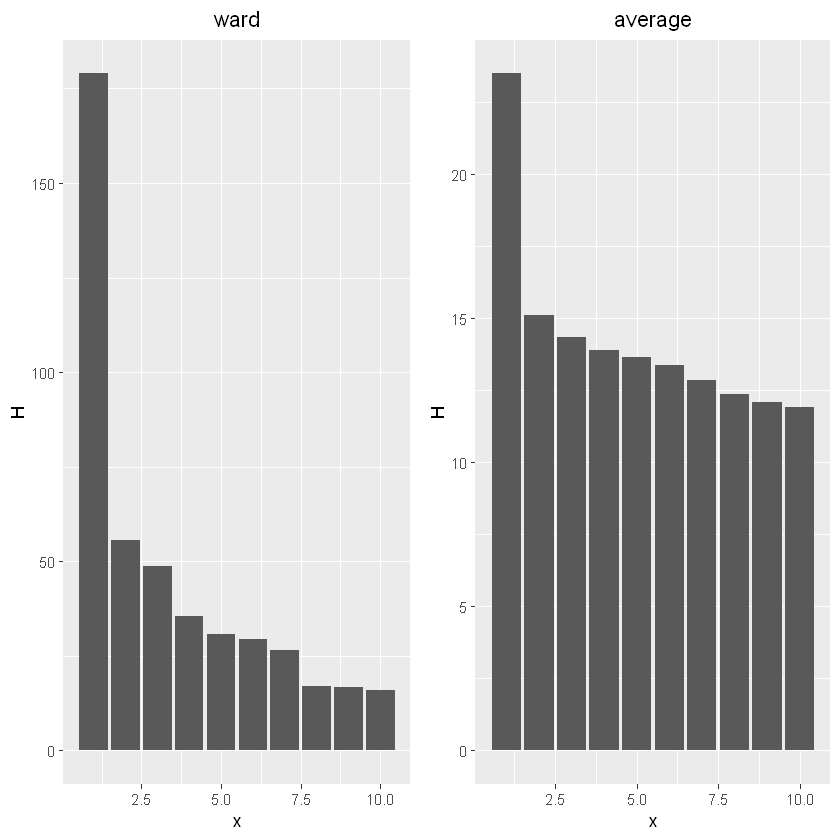

In [159]:
ggarrange(
    plotlist = hplots,
    ncol = 2, nrow = 1
)

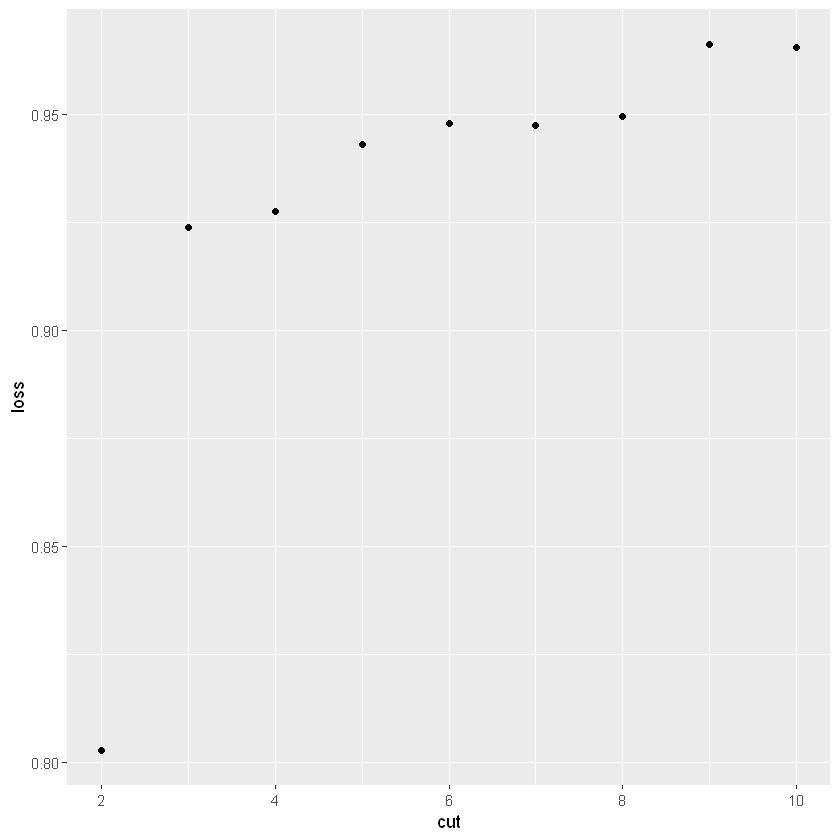

In [205]:
bestcut(ward)

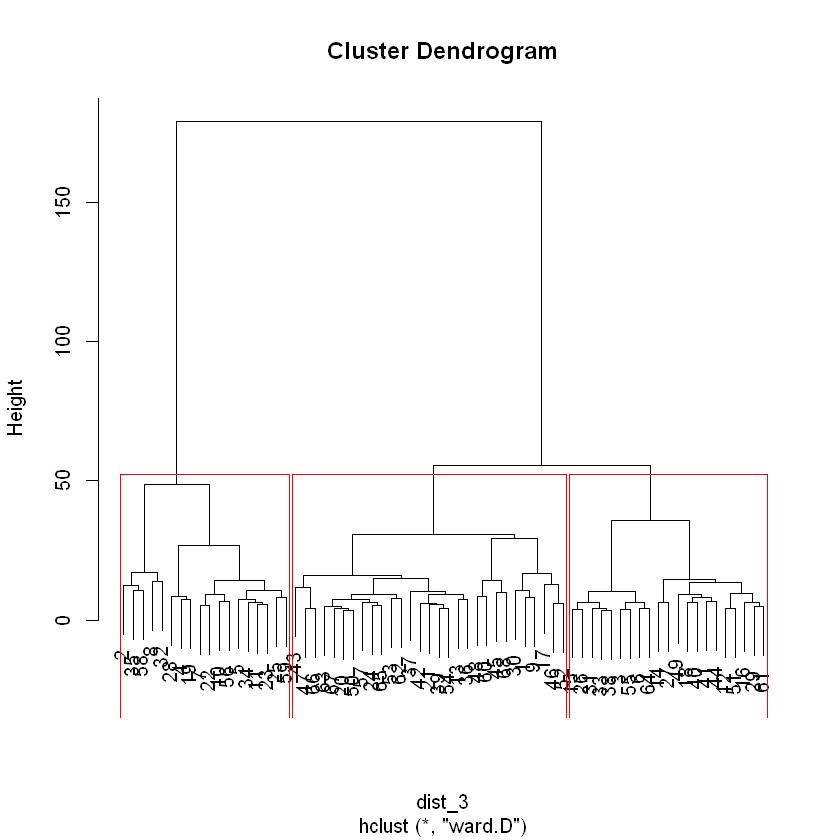

In [172]:
plot(ward)
rect.hclust(ward, 3)

Utilisons aussi l'algorithme des k_means avec 2 cluster et visualisons la distribution sur les 2 axes principaux.

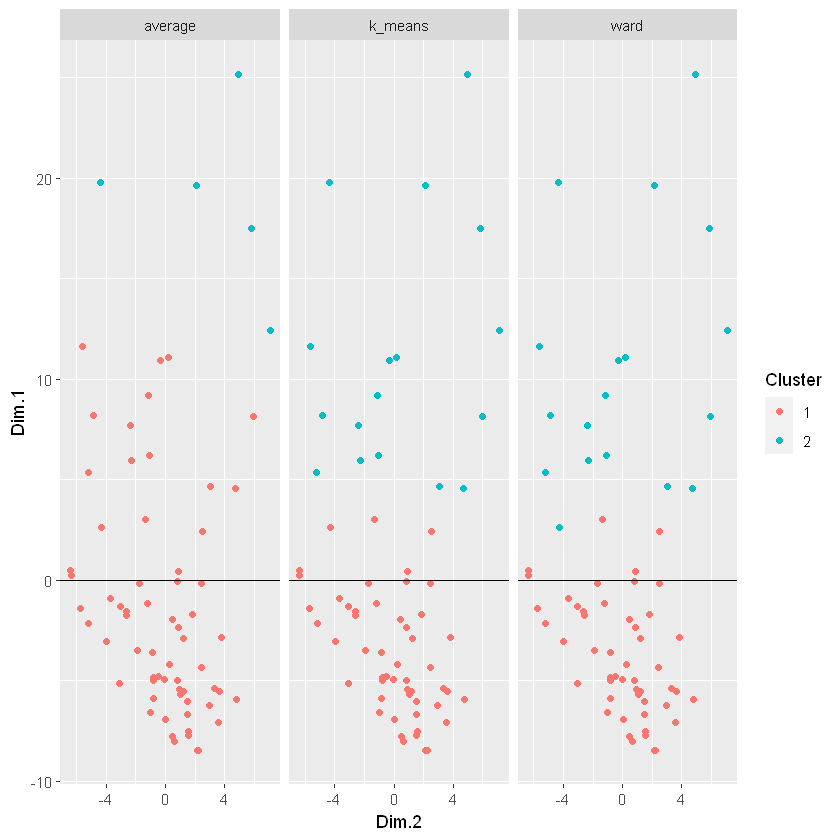

In [207]:
set.seed(2020)
k_means <- kmeans(scaled_3, 2)$cluster %>% as.factor()

pca_medical <- PCA(medical, scale.unit = T, ncp = 5, graph = F)

pca_medical$ind$coord %>% 
as_tibble() %>% 
mutate(
    ward = as.factor(cutree(ward, 2)),
    average = as.factor(cutree(average, 2)),
    k_means = k_means
) %>% 
gather("Algorithm", "Cluster", ward, average, k_means) %>% 
ggplot() + aes(x = Dim.2, y = Dim.1, color = Cluster) + geom_point() + 
geom_hline(yintercept = 0) + facet_wrap(Algorithm~.)

Comme attendu, la méthode de Ward découpe le mieux nos variables en réduisant le moins l'inertie inter-classe.  
On voit que le k mean découpe à un individu près les variables de la même façon.

2. On souhaite maintenant effectuer une classification de variables. C'est-à-dire qu'on ne veut plus regrouper les individus mais les 108 variables en classe homogênes. Adapter certains algorithmes du cours pour effectuer la meilleure classification de variables possibles. Si on souhaite faire une CAH par exemple, on pourra essayer d'utiliser une distance pertinente pour mesurer la proximité entre variables...

La méthode de Ward semble moins pertinent ici. Pour donner du poids à la proximité, on préfèrera la méthode single ou complete (dans le cas inverse de la proximité).  
Testons donc le clustering sur ces deux méthodes en y ajoutant quand même Ward pour voir comment il découpe.

In [220]:
set.seed(2020)
var_3 <- t(scaled_3)
dist_var <- dist(var_3)

complete <- hclust(dist_var, method = "complete")
ward <- hclust(dist_var, method = "ward.D")
single <- hclust(dist_var, method = "single")

In [221]:
heights <- tibble(
    complete = sort(complete$height, decreasing = T)[1:10],
    ward = sort(ward$height, decreasing = T)[1:10],
    single = sort(single$height, decreasing = T)[1:10]
)


hplots <- vector(mode = "list")
for (method in names(heights)){
    hplots[[method]] <- ggplot(heights) + 
    aes_string(x = 1:10, y = method) + geom_bar(stat = "identity") +
    labs(title = method, y = "H") + 
    theme(plot.title = element_text(hjust = 0.5))
}

On gardera 2 cluster en nous appuyant sur ces visualisations.

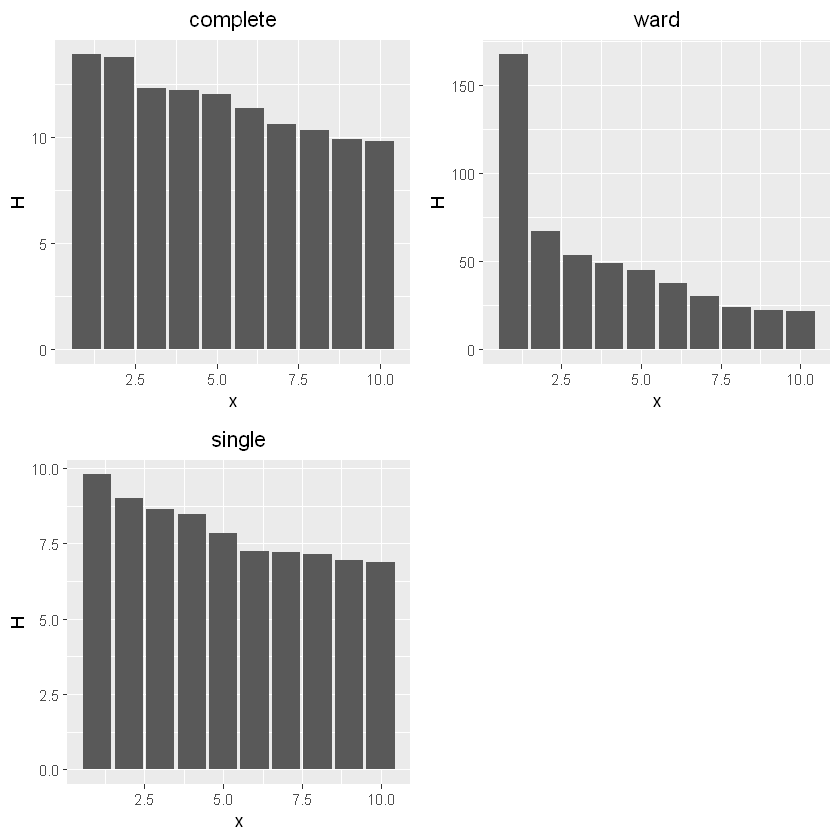

In [223]:
ggarrange(
    plotlist = hplots,
    ncol = 2, nrow = 2
)

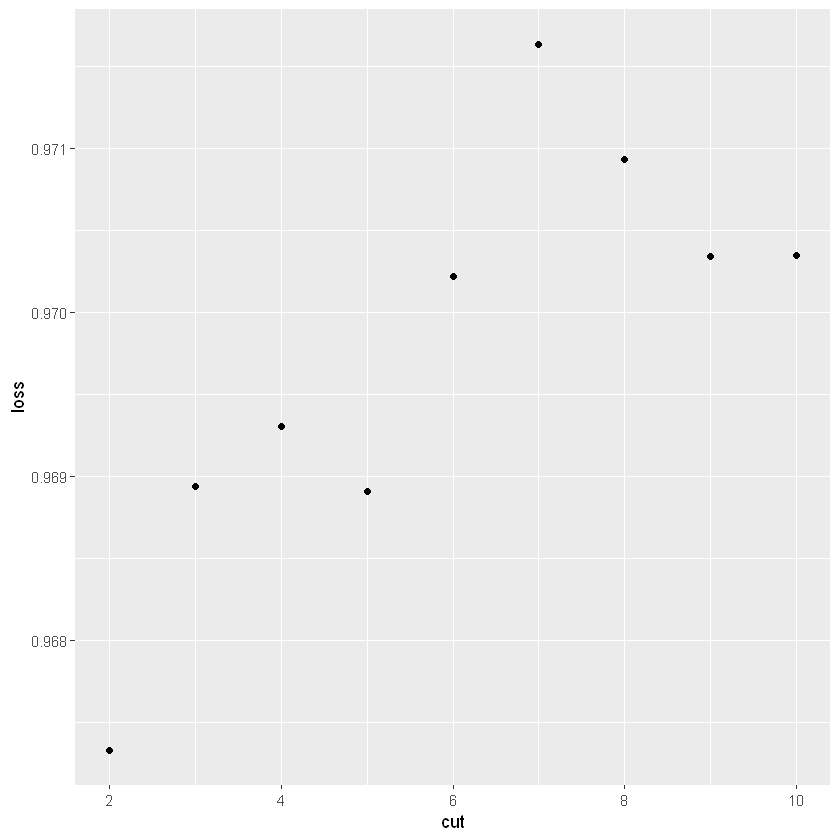

In [228]:
bestcut(single)

L'analyse des composantes principales montre aussi une division en deux groupes sur les 2 axes principales.

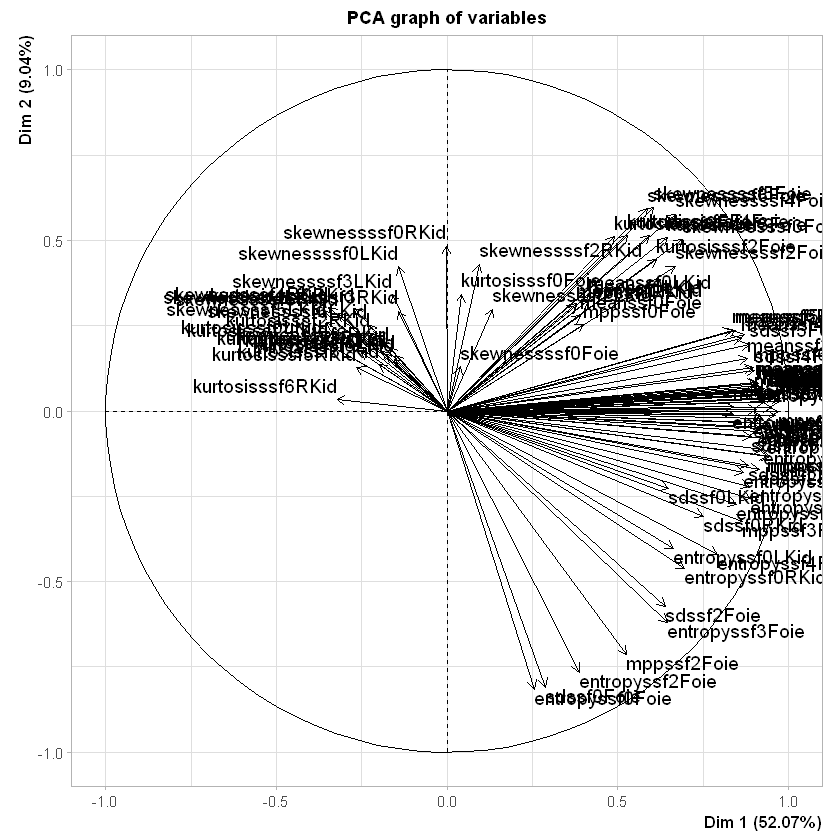

In [226]:
plot.PCA(pca_medical, axes=c(1, 2), choix="var")

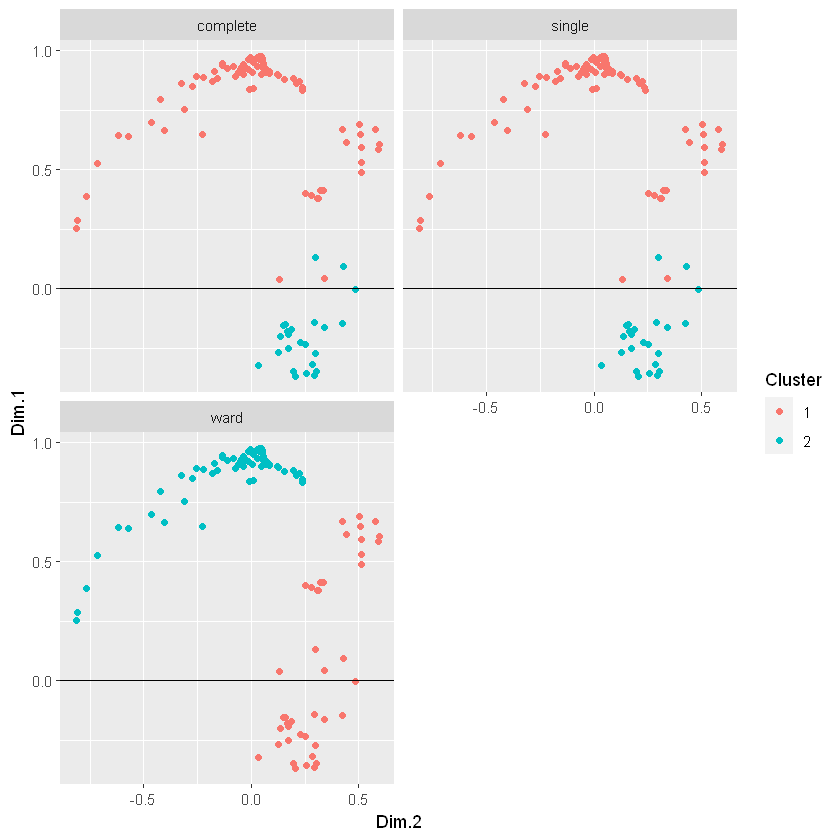

In [227]:
pca_medical$var$coord %>% 
as_tibble() %>% 
select(Dim.1, Dim.2) %>% 
mutate(
    ward = as.factor(cutree(ward, 2)),
    complete = as.factor(cutree(complete, 2)),
    single = as.factor(cutree(single, 2))
) %>% 
gather("Algorithm", "Cluster", ward, complete, single) %>% 
ggplot() + aes(x = Dim.2, y = Dim.1, color = Cluster) + geom_point() + 
geom_hline(yintercept = 0) + facet_wrap(Algorithm~., ncol = 2)

On voit donc que Ward ne découpe pas bien les variables par rapport à Single et complete.

3. Proposer une synthèse des deux analyses qui pourra comporter des conclusions à partir des groupes d'individus et de variables. Il s'agit d'essayer d'interpréter les résultats de ces deux analyses de façon conjointe. Il n'est pas interdit d'argumenter à partir d'indicateurs statistiques ou en utilisant des techniques de visualisation.

On peut dire que les individus sont séparés en malades/sains et les variables se divisent en 2 groupes où dans l'un une grande valeur est un bon résultats ce qui est l'inverse dans l'autre.